# Square Thermals with Partial Knowledge
Assume:
* thermals are square with a certain width and a constant vertical velocity
* we only know the vertical velocities along our UAV path

Try to find the position and width of the thermals we run into.


#36 Position: [3, 3], Observed:
[[  0.   0.  nan  nan  nan  nan  nan  nan]
 [ nan   0.   0.  nan  nan  nan   1.  nan]
 [  0.   0.   0.  nan  nan  nan   1.   0.]
 [  0.   0.  nan   0.  nan   1.   1.   0.]
 [  0.   1.  nan   0.   0.   0.   0.   0.]
 [  0.  nan   1.   0.   0.   0.   0.  nan]
 [ nan   0.  nan   0.   0.   0.   0.  nan]
 [ nan  nan  nan  nan   0.   0.  nan  nan]]
 [-----------------100%-----------------] 10000 of 10000 complete in 43.9 sec

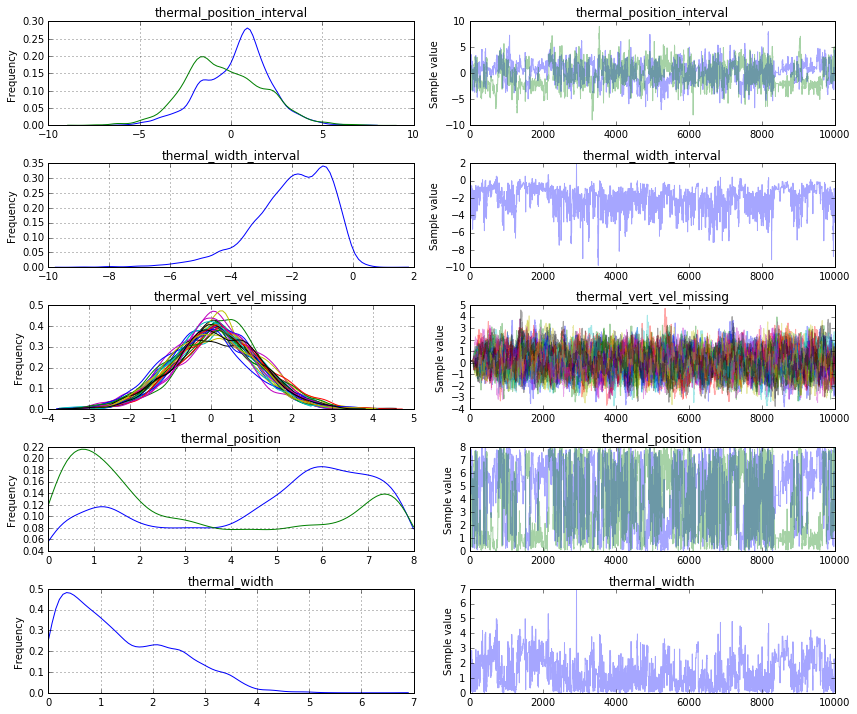

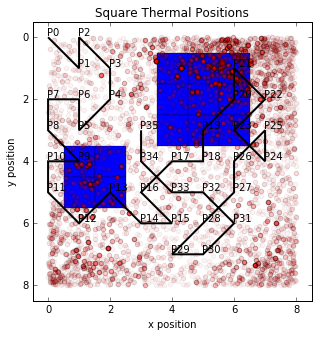

In [11]:
# For calculation
import sys
import random
import numpy as np
import pymc3 as pm
import scipy as sp
import theano
import theano.tensor as t

# For visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.path import Path
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches

# Display plots in Jupyter
%matplotlib inline

# For reproducibility
random.seed(126)
np.random.seed(123)

# From: http://stackoverflow.com/a/1401828
def dist(a, b):
    return np.linalg.norm(a-b)

# Create the path through the thermal field
def createPath(grid_size):
    # Create a random path through the grid
    path = [[0,0]] # (x,y)
    path_length = 35

    for i in range(0,path_length):
        # Where we presently are
        last = path[-1]
        # Figure out which of the 8 adjacent positions we can go to
        possibilities = [[-1,-1],[0,-1],[1,-1],
                         [-1,0],        [1,0],
                         [-1,1], [0,1], [1,1]]
        # Multiply amount to move by some number
        #multiple = random.randint(0,grid_size/2-1)
        #possibilities = [[a*multiple,b*multiple] for a,b in possibilities]
        # Add these offsets to the position we're currently at
        possible_positions = [[last[0]+offset[0],last[1]+offset[1]]
                              for offset in possibilities]
        # Remove any that are not within the grid and any that
        # we've already been to
        possible_positions = [pos for pos in possible_positions
                              if pos[0] >= 0 and pos[0] < grid_size
                             and pos[1] >= 0 and pos[1] < grid_size and
                             pos not in path]
        # Randomly select one of these positions and add it to our path
        path.append(random.choice(possible_positions))
    
    return path

# Vertical velocity as function of the thermal's position and width
#
# Note: this is going to view the thermal as more circular than square, but
# otherwise we'd also need to figure out the rotation of the thermal
@theano.compile.ops.as_op(itypes=[t.dvector, t.dscalar],otypes=[t.dmatrix])
def velocityGrid(thermal_position, thermal_width):
    out = np.empty([grid_size,grid_size])
    for y in range(0, grid_size):
        for x in range(0, grid_size):
            if dist([x,y], thermal_position) <= thermal_width:
                out[y,x] = 1
            else:
                out[y,x] = 0
    return out

#
# Create the visualization of the thermal field, our path,
# and where we think the thermals are
#
def visualize(data, path, trace):
    # Visualization
    fig = plt.figure(figsize=(5,5))
    plt.title('Square Thermal Positions')
    plt.xlabel('x position')
    plt.ylabel('y position')
    ax = plt.gca()
    ax.set_xlim([-0.5,grid_size+0.5])
    ax.set_ylim([-0.5,grid_size+0.5])
    ax.invert_yaxis() # +Y goes down

    # Square thermals, from: http://stackoverflow.com/a/5741363
    patches = []

    for y in range(0, len(data)):
        for x in range(0, len(data[0])):
            if data[y][x] == 1:
                patches.append(mpatches.Rectangle((x-0.5,y-0.5),1,1,ec="none"))

    collection = PatchCollection(patches, linewidth=0.25, edgecolors=(0,0,0,1))
    ax.add_collection(collection)

    # Path, from: http://matplotlib.org/users/path_tutorial.html
    codes = [Path.MOVETO if key is 0 else Path.LINETO
             for key, value in enumerate(path)]

    plot_path = Path(path, codes)
    patch_plot = mpatches.PathPatch(plot_path, facecolor='none', lw=2)
    ax.add_patch(patch_plot)

    for key, point in enumerate(path):
        ax.text(point[0]-0.05, point[1]-0.05, 'P'+str(key))

    # The learned values
    plt.scatter(trace["thermal_position"][:,0], trace["thermal_position"][:,1],
                alpha=0.05, c="r")

#
# Describe the thermal field, generate a path through it, and learn at
# each step in the path where we think the thermals are
#
data = np.array(
       [[0,0,0,0,0,0,0,0],
        [0,0,0,0,1,1,1,0],
        [0,0,0,0,1,1,1,0],
        [0,0,0,0,1,1,1,0],
        [0,1,1,0,0,0,0,0],
        [0,1,1,0,0,0,0,0],
        [0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0]])
grid_size = len(data[0])
#grid_size = 10
#grid = createGrid(grid_size, thermals)
path = createPath(grid_size)

traces = []

#for key, position in enumerate(path):
if True:
    # At the moment just do it at the end of the path
    key = len(path)
    position = path[-1]
    
    with pm.Model() as model:
        # Priors
        thermal_position = pm.Uniform("thermal_position", 0, grid_size, shape=2)
        thermal_width = pm.Uniform("thermal_width", 0, grid_size)
        vel = velocityGrid(thermal_position, thermal_width)

        # Path to this point
        path_history = path[:key+1]

        # Figure out what data we have observed, masking the values we have not
        # Masking example: https://github.com/pymc-devs/pymc3/wiki/DisasterModelMissing
        observed_data = np.array([[data[y,x] if [x,y] in path_history else np.nan
                         for x in range(0,grid_size)] for y in range(0,grid_size)])
        mask = np.ma.masked_invalid(observed_data)

        # Observe the vertical velocities
        thermal_vert_vel = pm.Normal('thermal_vert_vel', mu=vel, observed=mask)

        # Debugging
        print()
        print("#", key, " Position: ", position, ", Observed:", sep="")
        print(observed_data)
        sys.stdout.flush()

        # Sample this to find the posterior, note Metropolis works with discrete
        step = pm.Metropolis()
        traces.append(pm.sample(10000, step=step, progressbar=True))
        pm.traceplot(traces[-1]);
        plt.show()
        visualize(data, path_history, traces[-1])
        plt.show()